# Compute the power spectrum of topography for estimating the drag coefficient
Note that we need the power spectrum of ALL topography that contributes to wave generation, not just unresolved abyssal hills. In the 1-layer model, there's no internal wave generation. So we will need the topographic spectrum to include the smallest wavenumber (i.e., largest topography) that generates internal waves. 

Key steps:

1. Compute the spectrum (demean, window, integrate).
2. Assess the spectrum by plotting its integral (over all angles) against wavenumber modulus.
3. Overlay the slope for abyssal hills from GA2010 and G2010.

Examples:

https://github.com/rmholmes/cosima-scripts/blob/master/spectra_simple.ipynb

https://github.com/COSIMA/ACCESS-OM2-1-025-010deg-report/blob/master/figures/spectra/spectra.ipynb

Reference to read: 

https://journals.ametsoc.org/view/journals/mwre/145/9/mwr-d-17-0056.1.xml

In [1]:
%matplotlib inline

import xrft
import math
import scipy.io
import numpy as np
import xarray as xr
import netCDF4 as nc
import cmocean as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
from gsw import f
  
import warnings
warnings.filterwarnings('ignore')

## Estimate the horizontal wavelength of mode-1 internal wave to determine the radius of the circle (window for filtering)
The mode-n internal wave dispersion relation is $\omega_n^2 = f^2 + \frac{N^2H^2}{n^2\pi^2}k_h^2$.

For mode-1 $M_2$, the dispersion relation then becomes $\omega_{M_{2}}^2 = f^2 + \frac{N^2H^2}{\pi^2}k_h^2$

The horizontal wavenumber can be obtained following $k_h^2 = \frac{(\omega^2-f^2)\pi^2}{N^2H^2} $

In [2]:
omega_M2 = 2 * np.pi / (12*3600)
print('M2 frequency: %.5f rad/s' % omega_M2)

M2 frequency: 0.00015 rad/s


In [3]:
f_mid = f(45) 
print('f at 45deg N: %.5f rad/s' % f_mid)

f at 45deg N: 0.00010 rad/s


In [4]:
N = 2 * np.pi * 1e-3
print('Assume N = %.5f rad/s' % N)

Assume N = 0.00628 rad/s


In [5]:
H = 5000
print('Assume H = %d m' % H)

Assume H = 5000 m


In [6]:
kh = np.sqrt((omega_M2**2-f_mid**2)*np.pi**2/N**2/H**2)
print('The horizontal wavelength of the mode-1 M2 internal tides is approx. %d km.' % (2 * np.pi / kh / 1000))

The horizontal wavelength of the mode-1 M2 internal tides is approx. 612 km.


Let's select a grid point (30$^{\circ}$W, 50$^{\circ}$N) and plot the topography in a circle with a 300km radius around it.

High-res SYNBATH topog dataset: /g/data/nm03/lxy581/synbath/SYNBATH_V1.2.nc  (Downloaded from https://zenodo.org/records/5784502)

In [7]:
topog = xr.open_dataset('/g/data/nm03/lxy581/synbath/SYNBATH.nc')
xind = 240*150-1; yind = 240*140
print('Lon: %.1f W;' % np.abs(topog.lon[xind].values),'\nLat: %.1f N.' % topog.lat[yind].values)

Lon: 30.0 W; 
Lat: 50.0 N.


## Plot the ocean depth (demeaned!) in the selected region

In [8]:
topog_sample = topog.z[240*135:240*145,240*145:240*155]
topog_sample -= topog_sample.mean(skipna=True)

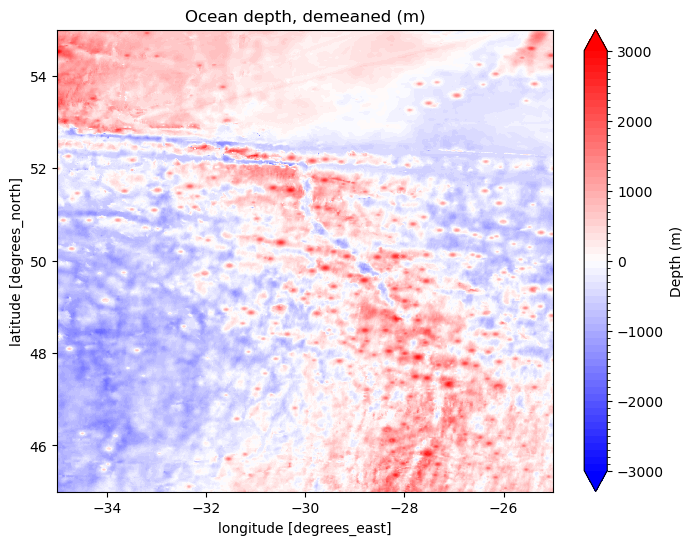

In [9]:
fig = plt.figure(figsize = (8, 6))
levels = np.arange(-3000,3000+1000,1000)
xr.plot.pcolormesh(topog_sample, vmin=-3000, vmax=3000, levels=61, extend='both', cmap='bwr', cbar_kwargs={'label': "Depth (m)", 'ticks': levels})
plt.title('Ocean depth, demeaned (m)');

## Construct a 2D isotropic filter to sample a circle around the selected grid point

In [10]:
#topog_sample

In [11]:
ydim, xdim = topog_sample.dims
nx = topog_sample[xdim].size
ny = topog_sample[ydim].size
dx = np.max(np.diff(topog_sample[xdim]))
dy = np.max(np.diff(topog_sample[ydim]))
win_2d = np.full((ny,nx), np.nan)
radi = topog_sample.shape[0] / 2
for i in range(topog_sample.shape[0]):
    for j in range(topog_sample.shape[0]):
        win_2d[j,i] = 1 - ( ((i-radi)/radi)**2 + ((j-radi)/radi)**2 )
win_2d[win_2d<0]=0

#### Compute the factor (constant) to compensate for the windowing effect so that the variance is conserved:

In [12]:
# testarr = np.arange(100)
# testwin = np.hanning(testarr.size)
# fac = np.sqrt(testarr.size / np.sum(testwin**2))
# fac - np.sqrt(8/3)
# testwin = np.hanning(testarr.size)*fac
# np.mean(testwin**2)
fac = np.sqrt(win_2d.size / np.sum(win_2d**2))
win_2d = win_2d * fac

In [13]:
win_2d_xr = xr.DataArray(win_2d, coords={'y': np.arange(ny), 'x': np.arange(nx)}, dims=["y", "x"])

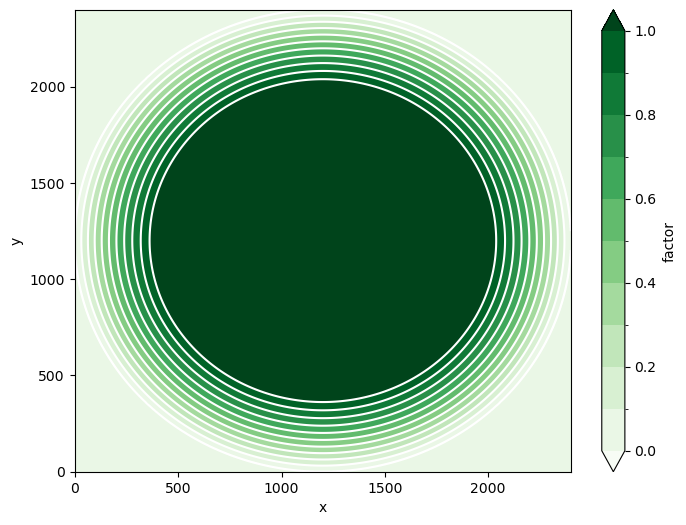

In [14]:
fig = plt.figure(figsize = (8, 6))
fac_levels = np.arange(0,1+0.2,0.2)
xr.plot.pcolormesh(win_2d_xr, vmin=0, vmax=1, levels=11, extend='both', cmap='Greens', cbar_kwargs={'label': "factor", 'ticks': fac_levels})
xr.plot.contour(win_2d_xr,levels=np.arange(0,1+0.1,0.1),colors='w')

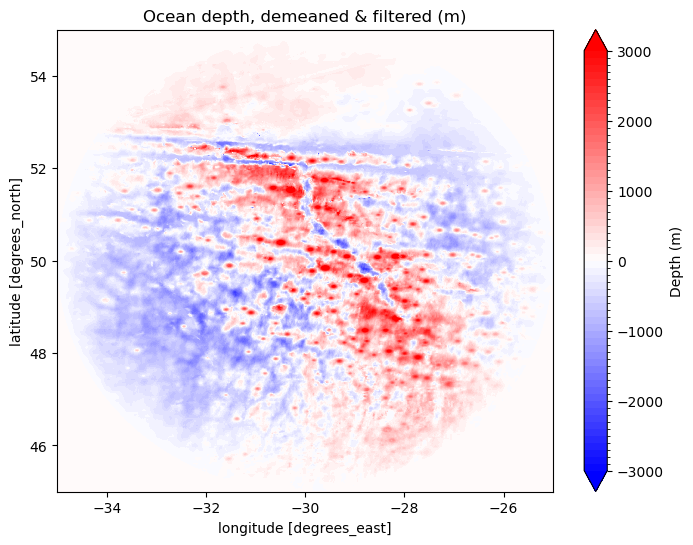

In [15]:
topog_filt = np.array(topog_sample) * np.array(win_2d_xr)
topog_filt = xr.DataArray(topog_filt, coords=topog_sample.coords, dims=topog_sample.dims)
fig = plt.figure(figsize = (8, 6))
levels = np.arange(-3000,3000+1000,1000)
xr.plot.pcolormesh(topog_filt, vmin=-3000, vmax=3000, levels=61, extend='both', cmap='bwr', cbar_kwargs={'label': "Depth (m)", 'ticks': levels})
plt.title('Ocean depth, demeaned & filtered (m)');

## Perform the spectral analysis

In [16]:
topog_fft = np.fft.fft2(topog_sample)
topog_fft = topog_fft / nx / ny
topog_spd = (topog_fft*topog_fft.conjugate()).real
topog_spd_xr = xr.DataArray(topog_spd, coords={'y': ny, 'x': nx}, dims=["KY", "KX"])

### Estimate kx and ky

In [17]:
kx = np.zeros(nx) 
for i in range(nx):
    kx[i] = i
    if kx[i] > nx / 2:
        kx[i] = nx - i
kx_fold = kx[0:1201]/nx/dx

ky = np.zeros(ny) 
for j in range(ny):
    ky[j] = j
    if ky[j] > ny / 2:
        ky[j] = ny - j
ky_fold = ky[0:1201]/nx/dx

kh = np.zeros((ny,nx))
for j in range(ny):
    for i in range(nx):
        kh[j,i] = np.sqrt(kx[i]**2 + ky[j]**2)
kh_max = round(np.sqrt( (nx/2)**2 + (ny/2)**2 ))
       
topog_spd_1d   = np.zeros((kh_max + 1))
topog_spd_fold = np.zeros((round(np.max(ky))+1,round(np.max(kx))+1))
for j in range(ny):
    for i in range(nx):
        jj = round(ky[j])
        ii = round(kx[i])
        ik = round(kh[j,i])
        topog_spd_1d[ik]      = topog_spd_1d[ik] + topog_spd[j,i] 
        topog_spd_fold[jj,ii] = topog_spd_fold[jj,ii]+topog_spd[j,i]

#### Needs to think carefully about dx for kh
#### What's done here is only an estimate, not accurate

In [18]:
dx = 110 * 1000 / 240 # 458 or less (m)
topog_spd_1d = topog_spd_1d * nx * dx
kh_1d = np.arange(kh_max+1) / nx / dx
#kh_1d.size, topog_spd_1d.size

## Read the slope for abyssal hills at this grid point from GA2010 and G2010

#### **G2010**: /home/581/lxy581/raijin_home_2019-11-15/lxy581/lw/goff2010_grids/goff2010_nu.grd 
#### **GA2010**: /home/581/lxy581/raijin_home_2019-11-15/lxy581/lw/goff.mat

In [19]:
mat_ga2010 = scipy.io.loadmat('/home/581/lxy581/raijin_home_2019-11-15/lxy581/lw/goff.mat')
nu_ga2010  = mat_ga2010['nu']
lon_ga2010 = mat_ga2010['lon'][0,:] # 1440
lat_ga2010 = mat_ga2010['lat'][:,0] # 580
xid_ga, yid_ga = 600, 480
lon_ga2010[xid_ga], lat_ga2010[yid_ga]

(-30.0, 50.0)

In [20]:
mat_g2010 = scipy.io.loadmat('/home/581/lxy581/raijin_home_2019-11-15/lxy581/lw/goff2010_grids/goff2010_nu.mat')
nu_g2010  = mat_g2010['nu'] #2250 x 5400
lon_g2010 = mat_g2010['x'][0,:] # 5400
lat_g2010 = mat_g2010['y'][0,:] # 2250
xid_g, yid_g = 2250, 1875
lon_g2010[xid_g], lat_g2010[yid_g]

(-30.0, 50.0)

In [21]:
slope_ga = -(nu_ga2010[yid_ga,xid_ga]+1)
slope_g  = -(nu_g2010[yid_g,xid_g]+1)
kh_abyssal = kh_1d[110:1200]
sp_abyssal_ga = 2e+0*kh_abyssal ** slope_ga
sp_abyssal_g  = 3e+0*kh_abyssal ** slope_g
slope_ga, slope_g

(-1.95, -1.9500005841255188)

## Plot the topographic spectrum as a function of wavenumber modulus

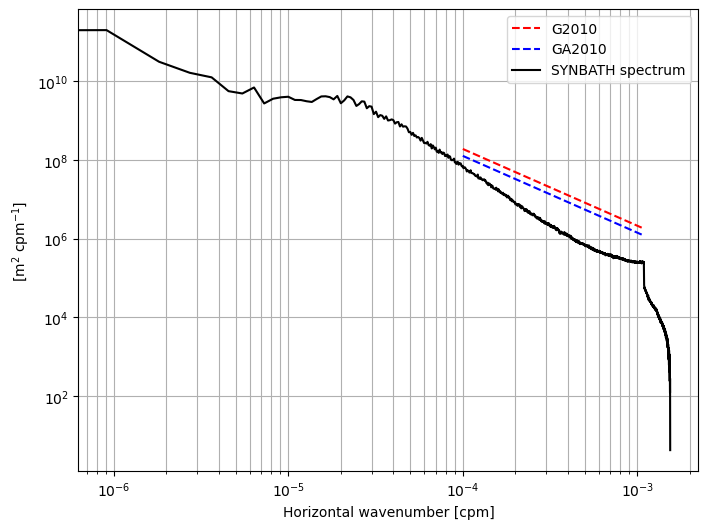

In [22]:
fig = plt.figure(figsize = (8,6))
plt.loglog(kh_abyssal, sp_abyssal_g, 'r--', label='G2010')
plt.loglog(kh_abyssal, sp_abyssal_ga, 'b--', label='GA2010')
plt.loglog(kh_1d,topog_spd_1d,'k-', label='SYNBATH spectrum')
plt.legend(loc=0)
plt.xlabel('Horizontal wavenumber [cpm]')
plt.ylabel('[m$^{2}$ cpm$^{-1}$]')
plt.grid(which='both', axis='both')

## Compute the drag coefficient at this location

Drag coefficient 

x dir: $\sigma_{xx} = \frac{N}{4\pi^2HA} \iint \text{ power spectrum } k^2 / \sqrt{k^2+l^2} dkdl$

y dir: $\sigma_{yy} = \frac{N}{4\pi^2HA} \iint \text{ power spectrum } l^2 / \sqrt{k^2+l^2} dkdl$

In [23]:
dk = kx_fold[1] - kx_fold[0]
dl = ky_fold[1] - ky_fold[0]
topog_spd_fold.shape, kx_fold.shape, ky_fold.shape
kx_2D, ky_2D = np.meshgrid(kx_fold,ky_fold,indexing='xy')
dk, dl

(0.09999999999940884, 0.09999999999940884)

In [24]:
A = (10*110*1e+3)**2
const = N / (4 * np.pi**2 * H * A)
topog_spd_final = topog_spd_fold * nx**2 * dx**2
int_x = topog_spd_final * kx_2D**2 / np.sqrt(kx_2D**2 + ky_2D**2) * dk * dl
int_y = topog_spd_final * ky_2D**2 / np.sqrt(kx_2D**2 + ky_2D**2) * dk * dl
sigma_x = const * np.nansum(int_x[:])
sigma_y = const * np.nansum(int_y[:])
sigma_x, sigma_y

(5.7870198189609404e-05, 7.940968069444955e-05)